In [ ]:
import argparse
import copy
from collections import defaultdict
import datetime as dt
import glob
import re
import json
import shutil
import os
import pickle
import yaml
import math
import time
from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from comet_ml import API
import os
from typing import List
import copy
import functools

In [ ]:
from pose_tracking.utils.args_parsing import load_args_from_file
from pose_tracking.config import prepare_logger
from pose_tracking.utils.pipe_utils import Printer
from pose_tracking.utils.args_parsing import postprocess_args
from pose_tracking.utils.pipe_utils import get_model
from pose_tracking.config import ARTIFACTS_DIR
from pose_tracking.utils.comet_utils import load_artifacts_from_comet
from pose_tracking.dataset.custom import CustomDatasetTest
from pose_tracking.utils.vis import plot_sample_dict
from pose_tracking.utils.geom import convert_2d_t_to_3d
from pose_tracking.trainer_memotr import filter_by_score
from pose_tracking.utils.detr_utils import postprocess_detr_boxes
from pose_tracking.utils.pose import convert_pose_vector_to_matrix
from pose_tracking.utils.vis import draw_poses_on_video, make_grid_image, vis_pose
from pose_tracking.metrics import calc_metrics_agg
from pose_tracking.utils.vis import vis_bbox_2d
from pose_tracking.config import DATA_DIR

from memotr.structures.track_instances import TrackInstances
from memotr.models.runtime_tracker import RuntimeTracker
from memotr.utils.nested_tensor import tensor_list_to_nested_tensor

In [ ]:
api = API(api_key=os.environ["COMET_API_KEY"])

<Axes: >

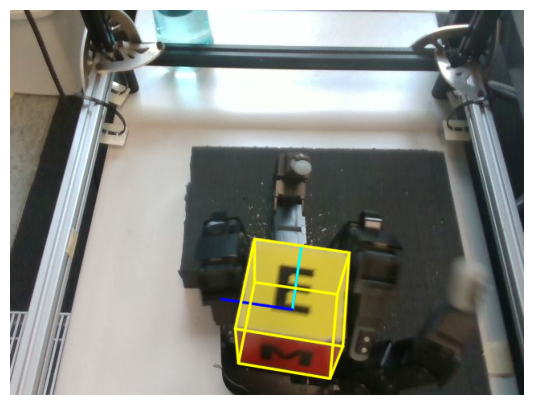

In [11]:
from pose_tracking.utils.vis import plot_sample_pose_dict


env_dir=f'{DATA_DIR}/custom/allegro_real/pose_estimator_synced_2025-05-05-18-21-47'
ds = CustomDatasetTest(
        video_dir=env_dir,
        include_mask=True,
        obj_name="object_0",
        include_bbox_2d=True,
        mask_dirname="masks",
        rot_repr=None,
        end_frame_idx=20,
        t_repr=None,
        use_mask_for_visibility_check=False
    )
plot_sample_pose_dict(ds[0])

In [ ]:
def fix_args_for_exp(exp_name, args):
    if exp_name in ["equal_sap_2057"]:
        args.encoder_name = "resnet50"
    if exp_name in ["urgent_vicuna_6331"]:
        args.use_v1_code = True
    if exp_name in ["azure_legend_8893"]:
        args.depth_decoder_num_layers = 2
        args.hidden_attn_num_layers = 2
    elif exp_name in ["tender_moss_374", "disastrous_rice_1063"]:
        args.r_num_layers_inc = 1
    return args

In [ ]:
logger = prepare_logger("/tmp/test.log")
printer = Printer(logger)

exp_name = "urgent_vicuna_6331"  # memotr dextreme
exp_dir = Path(ARTIFACTS_DIR / exp_name)
exp_dir.mkdir(parents=True, exist_ok=True)
artifact_suffix = "best"
download_res = load_artifacts_from_comet(
    exp_name,
    api=api,
    artifact_suffix=artifact_suffix,
    do_force_download=False,
)
args = load_args_from_file(exp_dir / "args.yaml")
args = postprocess_args(args)
args = fix_args_for_exp(exp_name, args)
args.use_ddp = False
args.do_debug = False
args.do_debug = True
args.ckpt_path = download_res["checkpoint_path"]
args.num_classes = 1

model = get_model(args, num_classes=args.num_classes)
torch.set_grad_enabled(False)
model.eval().cuda()
for p in model.parameters():
    p.requires_grad = False

loading artifacts for exp_name='urgent_vicuna_6331'
Loading the model from step 73


/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from /mnt/t7/msc_studies/pose_estimation/object_pose_tracking/artifacts/urgent_vicuna_6331/model_best.pth
0 parameters not in model, 0 not in ckpt


In [6]:
len(ds)

20

In [ ]:
pose_to_mat_converter_fn = functools.partial(
    convert_pose_vector_to_matrix, rot_repr=args.rot_repr
)
failed_ts = []
fp_ts = []

tracker = RuntimeTracker(
    det_score_thresh=0.5,
    track_score_thresh=0.5,
    miss_tolerance=30,
    use_motion=False,
    motion_min_length=0,
    motion_max_length=0,
    visualize=False,
    use_dab=args.tf_use_dab,
    matcher=None,
)
device = "cuda"
tracks = [
    TrackInstances(
        hidden_dim=model.hidden_dim,
        num_classes=model.num_classes,
        use_dab=args.tf_use_dab,
    ).to(device)
]
ts = list(range(0, len(ds)))

use_bbox = True
use_gt = ds.include_pose
mesh_bbox = ds.mesh_bbox

poses_pred = []
rgbs = []
imgs_bbox = []
det_ress = []
poses_gt = []
bbox_gts = []
trackss = []
extra_texts = []

pose_mat_pred_abs_last = None
bbox_last = None
for t in tqdm(ts):
    x = ds[t]
    rgb = x["rgb"]
    if use_gt:
        bbox_gt = x["bbox_2d"]
        pose_gt = copy.deepcopy(x["pose"])
    h, w = rgb.shape[-2:]
    frame = tensor_list_to_nested_tensor(tensor_list=rgb[None]).to(device)
    res = model(frame=frame, tracks=tracks)

    previous_tracks, new_tracks = tracker.update(model_outputs=res, tracks=tracks)
    tracks: List[TrackInstances] = model.postprocess_single_frame(
        previous_tracks, new_tracks, None
    )
    tracks_result = tracks[0].to(torch.device("cpu"))
    result_score_thresh = 0.5
    score = torch.max(tracks_result.scores, dim=-1).values
    tracks_result = filter_by_score(tracks_result, thresh=result_score_thresh)
    tracks_result.boxes = postprocess_detr_boxes(
        tracks_result.boxes, target_sizes=torch.tensor([[h, w]])
    )

    bbox = tracks_result.boxes
    det_res = {
        "bbox": bbox,
        "labels": tracks_result.labels,
        "scores": score,
        "track_ids": tracks_result.ids,
    }
    track_ts = tracks_result.ts
    intrinsics = x["intrinsics"]
    if len(track_ts) > 0:
        if args.do_predict_2d_t:
            center_depth_pred = track_ts[..., 2:]
            t_pred_2d = track_ts[..., :2]
            convert_2d_t_pred_to_3d_res = convert_2d_t_to_3d(
                t_pred_2d, center_depth_pred, [i.cpu() for i in [intrinsics]], hw=(h, w)
            )
            track_ts = convert_2d_t_pred_to_3d_res["t_pred"]
        pose_mat_pred_abs = pose_to_mat_converter_fn(
            torch.cat([track_ts, tracks_result.rots], dim=-1)
        )
    else:
        pose_mat_pred_abs = torch.eye(4).unsqueeze(0).to(device)
        pose_mat_pred_abs = pose_mat_pred_abs_last
        bbox = bbox_last
        failed_ts.append(t)

    if len(det_res["scores"]) == 0:
        det_res["scores"] = torch.tensor(-1)
    elif len(det_res["scores"]) > 1:
        fp_ts.append(t)
        max_score, max_idx = torch.max(det_res["scores"], dim=-1)
        det_res["scores"] = det_res["scores"][max_idx]
        pose_mat_pred_abs = pose_mat_pred_abs[max_idx : max_idx + 1]

    score_format = round(score.item(), 2)
    extra_text = f"{t=} score={score_format}"
    if use_gt:
        img = vis_pose(
            rgb, pose_gt, K=intrinsics, bbox=mesh_bbox, bbox_color=(0, 255, 0)
        )
    else:
        img = rgb
    if use_bbox:
        img_bbox = vis_bbox_2d(rgb, bbox, label=extra_text)
        if use_gt:
            bbox_gts.append(bbox_gt)
            img_bbox = vis_bbox_2d(img_bbox, bbox_gt, color=(0, 255, 0))
        imgs_bbox.append(img_bbox)
    rgbs.append(img)

    poses_pred.append(pose_mat_pred_abs)
    det_ress.append(det_res)
    trackss.append(tracks_result)
    poses_gt.append(x["pose"])
    extra_texts.append(extra_text)

    pose_mat_pred_abs_last = pose_mat_pred_abs
    bbox_last = bbox

if len(failed_ts) > 0:
    print(f"WARNING: {failed_ts=}")
if len(fp_ts) > 0:
    print(f"WARNING: {fp_ts=}")
scores = [res["scores"] for res in det_ress]
boxes = [res["bbox"] for res in det_ress]

imgs = draw_poses_on_video(
    rgbs,
    intrinsics=ds.K,
    poses_pred=poses_pred,
    bbox=mesh_bbox,
    extra_texts=extra_texts,
)

if use_gt:
    metrics_all_agg = calc_metrics_agg(
        poses_pred, poses_gt, bbox_3d=mesh_bbox, pts=ds.mesh_pts
    )
    print(metrics_all_agg)

len(ds)=20


  0%|          | 0/20 [00:00<?, ?it/s]

/home/master/.conda/envs/pt/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 20/20 [00:00<00:00, 132.43it/s]

{'add': 0.016132439323700964, 'r_err': 9.453638, 't_err': 0.015620148507878184, '15deg15cm': 0.8, '10deg10cm': 0.55, '5deg5cm': 0.45, '2deg2cm': 0.1}


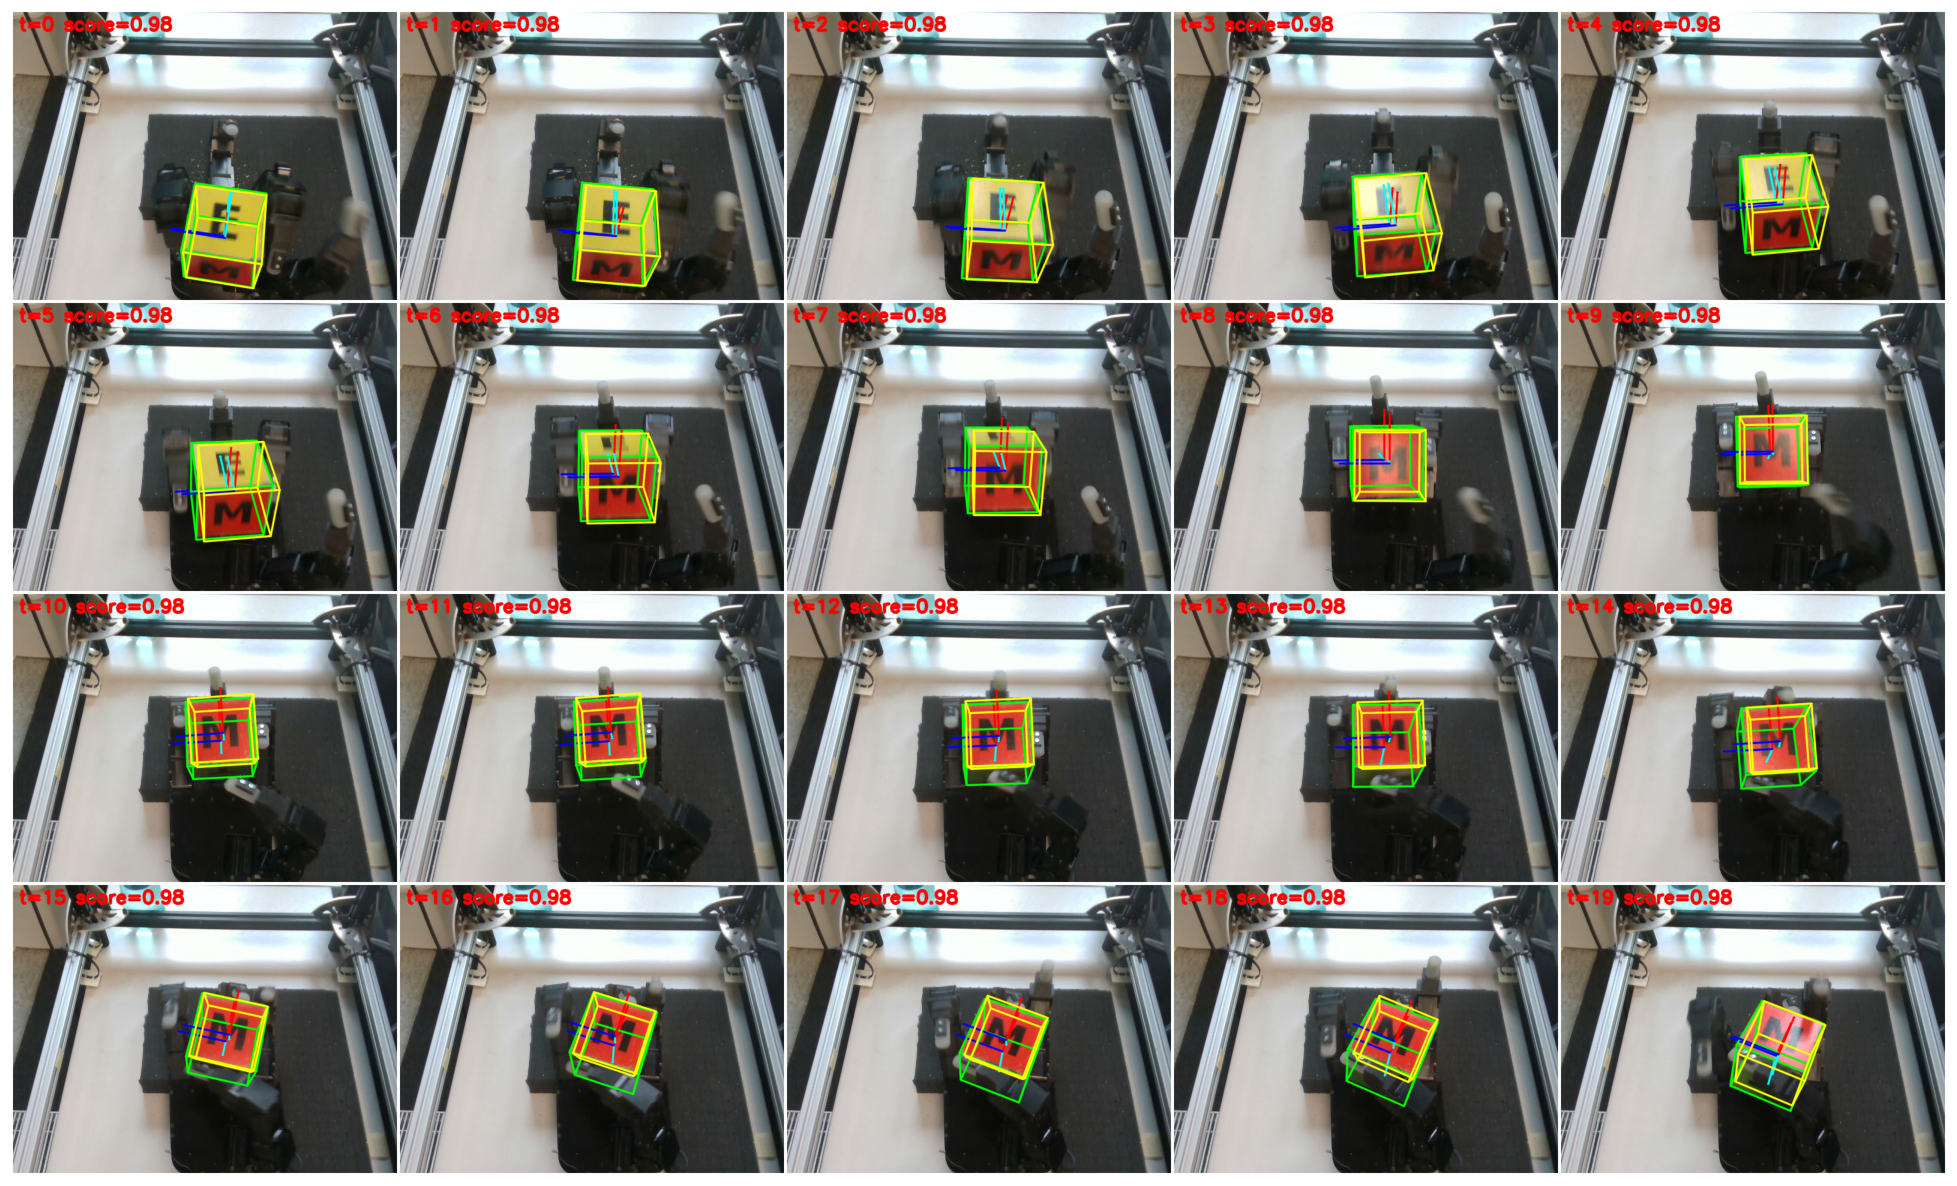

In [8]:
make_grid_image(imgs)